https://flax.readthedocs.io/en/latest/nnx_basics.html

Next: Figure out what's going on with Flax and why this doesn't work

Currently running into errors when specifying the RNGs. JAX handles the keys explicitly, where you have to split the key before using it again. But NNX is supposed to be managing the RNGs internally in a "Pythonic" way so that it manages it itself without any manual editing by me.

But I'm running into weird errors .. 

In [1]:
from flax import nnx
import jax
import jax.numpy as jnp

### Flax basics

In [7]:
class Linear(nnx.Module):
    ''' Defining a linear layer using NNX modules
        
        rngs: nnx.Rngs is an object containing "streams" of random numbers 
                based on what params is originally passed
        
    '''
    def __init__(self, din: int, dout: int, *, rngs: nnx.Rngs):
        
        key = rngs.params()
        
        self.w = nnx.Param(jax.random.uniform(key, (din, dout)))
        self.b = nnx.Param(jnp.zeros((dout,)))
        self.din, self.dout = din, dout

    def __call__(self, x: jax.Array):
        return x @ self.w + self.b[None]

In [6]:
model = Linear(2, 5, 
               rngs=nnx.Rngs(params=0))

y = model(x=jnp.ones((1, 2)))

print(y)
nnx.display(model)

[[1.5643291  0.94782424 0.37971854 1.0724319  0.22112393]]


With NNX you can make state updates to variables, which is unlike normal JAX compatibility

In [11]:
class Count(nnx.Variable): pass

class Counter(nnx.Module):

    def __init__(self):
        # calls Count, which is now an nnx.Variable, which is useful
        # for things like batch norm where we are normalizing over a batch
        self.count = Count(jnp.array(0))

    def __call__(self):
        self.count[...] += 1

counter = Counter()
print(f'{counter.count[...] = }')
counter()
print(f'{counter.count[...] = }')

counter.count[...] = Array(0, dtype=int32, weak_type=True)
counter.count[...] = Array(1, dtype=int32, weak_type=True)


From Gemini, let's come up with an example of learning some function

First let's define the MLP

In [12]:
class MLP(nnx.Module):
    def __init__(self, din, dhidden, dout, *, rngs: nnx.Rngs):
        # 1. Pass 'rngs' to the first layer.
        # It calls rngs.params(), gets Key #1, and advances the stream.
        self.layer1 = nnx.Linear(din, dhidden, rngs=rngs)

        # network looks like: din --> dhidden --> dout
        
        # 2. Pass the SAME 'rngs' object to the second layer.
        # It calls rngs.params(), gets Key #2 (automatically unique).
        self.layer2 = nnx.Linear(dhidden, dout, rngs=rngs)

    def __call__(self, x):
        # Pass x through layer 1, followed by activation, then layer 2
        x = self.layer1(x)
        x = jax.nn.relu(x) # Standard activation function
        x = self.layer2(x)
        return x

In [15]:
# specify the random number generation stream
rngs = nnx.Rngs(params=0)

# We initialize the whole MLP at once
model = MLP(din=2, 
            dhidden=10, 
            dout=5, 
            rngs=rngs)

# Run it
y = model(jnp.ones((1, 2)))
print(y) # these outputs are what happens when we pass the ones through the network
nnx.display(model)

[[-0.15895452 -1.1049775   1.2165147   0.62828314  0.571608  ]]


Now let's do an example

In [16]:
X = jnp.linspace(0, 1, 100)[:, None]  # Shape (100, 1)
Y = 2 * X + 1 + 0.1 * jax.random.normal(jax.random.key(0), (100, 1)) # Add noise

Our data is shaped (100,1). We have 100 data points, or examples, and then for each example we have 1 feature which characterizes the data point. This means that our input and output dimensions of the model should match this number of features

Compare this to e.g. MNIST digits where we'd have (10, (28, 28)). Our flattened feature dimension would be 28x28=784, meaning that the input dimension of the model should be 784. And we have 10 images in this case. THen, because we are trying to predict what digit corresponds to which output, our output dimensions should be 10!

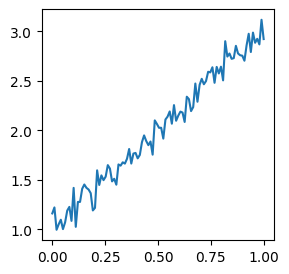

In [36]:
import matplotlib.pyplot as plt
import optax
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.plot(X, Y)

In [37]:
# now let's create our model
rngs = nnx.Rngs(params=0)
model = MLP(din=1,
            dhidden=10,
            dout=1,
            rngs=rngs)

# specify sgd optimizer
optimizer = nnx.Optimizer(model, optax.sgd(learning_rate=0.1))

In [34]:
# and now let's formulate the training step
@nnx.jit
def train_step(model, optimizer, x, y):
    ''' One step in the training process
    
        args
            model: the model
            optimizer of choice
            X is the input data
            Y is the true data distribution
    '''
    # A internal function that calculates loss
    def loss_fn(model):
        # obtain the predictions of the model itself
        y_pred = model(x) 
        
        # calculated cost as mean squared distance (?)
        loss = jnp.mean((y_pred - y) ** 2)
        return loss

    # nnx.value_and_grad works just like jax.value_and_grad
    # It tracks the gradients with respect to the 'model' parameters
    loss, grads = nnx.value_and_grad(loss_fn)(model)

    # Update the parameters in-place!
    optimizer.update(grads)

    return loss

In [40]:
print(f"Initial Loss: {train_step(model, optimizer, X, Y)}")

# for how many steps we want to train 
for step in range(100):
    # get the loss
    loss = train_step(model, optimizer, X, Y)
    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Verify results
#print(f"\nLearned Weight (should be ~2.0): {model.layer1.value}")
#print(f"Learned Bias (should be ~1.0): {model.b.value}")

Initial Loss: 0.008863644674420357
Step 0, Loss: 0.0089
Step 10, Loss: 0.0089
Step 20, Loss: 0.0089
Step 30, Loss: 0.0089
Step 40, Loss: 0.0089
Step 50, Loss: 0.0089
Step 60, Loss: 0.0089
Step 70, Loss: 0.0089
Step 80, Loss: 0.0089
Step 90, Loss: 0.0089


In [51]:
print(model.layer1)

Linear( # Param: 20 (80 B)
  bias=Param( # 10 (40 B)
    value=Array(shape=(10,), dtype=dtype('float32'))
  ),
  bias_init=<function zeros at 0x747e559057e0>,
  dot_general=<function dot_general at 0x747e66dbb010>,
  dtype=None,
  in_features=1,
  kernel=Param( # 10 (40 B)
    value=Array(shape=(1, 10), dtype=dtype('float32'))
  ),
  kernel_init=<function variance_scaling.<locals>.init at 0x747e47cf95a0>,
  out_features=10,
  param_dtype=float32,
  precision=None,
  promote_dtype=<function promote_dtype at 0x747e47cf9510>,
  use_bias=True
)
